<a href="https://colab.research.google.com/github/natitedros/WAVN-Federated-Learning/blob/main/CNN_Homing_FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split

Mounted at /content/drive


In [2]:
CSV_PATH = '/content/drive/MyDrive/gazebo_dataset_fl/labels.csv'
IMG_DIR = '/content/drive/MyDrive/gazebo_dataset_fl/images/'

In [3]:
df = pd.read_csv(CSV_PATH)
print(f"Total samples: {len(df)}")
print(f"\nFirst few rows:\n{df.head()}")
print(f"\nDirection counts:\n{df['direction'].value_counts()}")

Total samples: 121

First few rows:
          current_image     destination_image direction
0      0001_current.png  0001_destination.png   forward
1      0002_current.png  0002_destination.png  backward
2      0003_current.png  0003_destination.png     right
3  0003_destination.png      0003_current.png      left
4      0004_current.png  0004_destination.png   forward

Direction counts:
direction
right       31
forward     30
backward    30
left        30
Name: count, dtype: int64


In [4]:
direction_map = {'forward': 0, 'backward': 1, 'left': 2, 'right': 3}
df['direction_label'] = df['direction'].map(direction_map)
num_clients = 2
shard_size = len(df) // num_clients
print(f"first few rows after direction mapping:\n{df.head()}")

first few rows after direction mapping:
          current_image     destination_image direction  direction_label
0      0001_current.png  0001_destination.png   forward                0
1      0002_current.png  0002_destination.png  backward                1
2      0003_current.png  0003_destination.png     right                3
3  0003_destination.png      0003_current.png      left                2
4      0004_current.png  0004_destination.png   forward                0


In [5]:
client_datasets = []
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

for i in range(num_clients):
    start = i * shard_size
    end = start + shard_size
    shard = df_shuffled.iloc[start:end]

    # For each shard create train/val split
    train_df, val_df = train_test_split(shard, test_size=0.2, random_state=42)

    client_datasets.append((train_df, val_df))
    print(f"\nClient: {i+1}")
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")


Client: 1
Training samples: 48
Validation samples: 12

Client: 2
Training samples: 48
Validation samples: 12


In [6]:
# Function to load image
def load_image(img_path):
    img = load_img(IMG_DIR + img_path, target_size=(128, 128))
    img = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return img

In [7]:
# Creating the dataset
def create_dataset(dataframe, batch_size=32):
    current_images = []
    dest_images = []
    labels = []

    for idx, row in dataframe.iterrows():
        current_img = load_image(row['current_image'])
        dest_img = load_image(row['destination_image'])

        current_images.append(current_img)
        dest_images.append(dest_img)
        labels.append(row['direction_label'])

    current_images = np.array(current_images)
    dest_images = np.array(dest_images)
    labels = np.array(labels)

    return current_images, dest_images, labels

In [8]:
client_train_data = []
client_val_data = []

for i, (train_df, val_df) in enumerate(client_datasets):

  print(f"\nClient: {i+1}")
  print("Loading training data...")
  X_train_current, X_train_dest, y_train = create_dataset(train_df)

  print("Loading validation data...")
  X_val_current, X_val_dest, y_val = create_dataset(val_df)

  client_train_data.append((X_train_current, X_train_dest, y_train))
  client_val_data.append((X_val_current, X_val_dest, y_val))
  print(f"\nTraining data shapes:")
  print(f"Current images: {X_train_current.shape}")
  print(f"Destination images: {X_train_dest.shape}")
  print(f"Labels: {y_train.shape}")


Client: 1
Loading training data...
Loading validation data...

Training data shapes:
Current images: (48, 128, 128, 3)
Destination images: (48, 128, 128, 3)
Labels: (48,)

Client: 2
Loading training data...
Loading validation data...

Training data shapes:
Current images: (48, 128, 128, 3)
Destination images: (48, 128, 128, 3)
Labels: (48,)


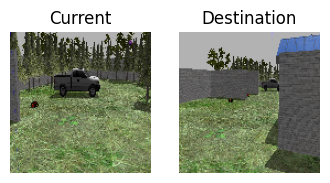

Direction: 1


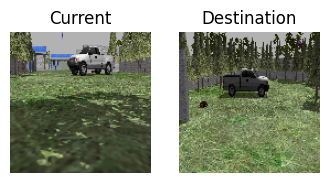

Direction: 1


In [9]:
import matplotlib.pyplot as plt

def show_pair(idx):
    plt.figure(figsize=(4,4))

    # show current image
    plt.subplot(1, 2, 1)
    plt.imshow(client_train_data[0][0][idx])
    plt.title("Current")
    plt.axis('off')

    # show destination image
    plt.subplot(1, 2, 2)
    plt.imshow(client_train_data[0][1][idx])
    plt.title("Destination")
    plt.axis('off')

    plt.show()

    print(f"Direction: {client_train_data[0][2][idx]}")

# show a few random samples
for i in [0, 5]:
    show_pair(i)


In [10]:
# for each client
for i, (Xc, Xd, y) in enumerate(client_train_data):
    print("Client", i+1)
    print(np.unique(y, return_counts=True))
    print("n_train:", len(y))
for i, (Xc, Xd, y) in enumerate(client_val_data):
    print("Client val", i+1, np.unique(y, return_counts=True))


Client 1
(array([0, 1, 2, 3]), array([11, 10, 14, 13]))
n_train: 48
Client 2
(array([0, 1, 2, 3]), array([13, 13,  9, 13]))
n_train: 48
Client val 1 (array([0, 1, 2, 3]), array([3, 3, 5, 1]))
Client val 2 (array([0, 1, 2, 3]), array([3, 4, 1, 4]))


In [11]:
from tensorflow.keras import layers, models

def create_model(num_classes=4):
    # Inputs
    current_input = layers.Input(shape=(128,128, 3), name='current_image')
    dest_input = layers.Input(shape=(128, 128, 3), name='destination_image')

    # Simple CNN branch
    def cnn_branch(x):
        x = layers.Conv2D(32, 3, activation="relu")(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Conv2D(64, 3, activation="relu")(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Conv2D(128, 3, activation="relu")(x)
        x = layers.GlobalAveragePooling2D()(x)
        return x

    # Both branches
    current_features = cnn_branch(current_input)
    dest_features = cnn_branch(dest_input)

    # Combine
    combined = layers.concatenate([current_features, dest_features])

    # Dense layers
    x = layers.Dense(16, activation='relu')(combined)
    output = layers.Dense(num_classes, activation='softmax')(x)

    # Model
    model = models.Model(inputs=[current_input, dest_input], outputs=output)
    return model


In [12]:
model = []
for i in range(num_clients):
    model.append(create_model(num_classes=4))
model[0].summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ current_image       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destination_image   │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        896 │ current_image[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 126, 126,  │        896 │ destination_imag… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 63, 63,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 30, 30,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_5[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │      4,112 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │         68 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 190,676 (744.83 KB)

 Trainable params: 190,676 (744.83 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
for i in range(num_clients):
    model[i].compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [14]:
# Strong but geometry-preserving augmentations
# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.15,
#     height_shift_range=0.15,
#     shear_range=0.1,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     brightness_range=[0.7, 1.3],
#     channel_shift_range=20.0,
#     fill_mode='reflect'  # better than nearest for robotics images
# )
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    # fill_mode='reflect'
)
def paired_generator(current_images, dest_images, labels, batch_size=8):
    n = len(labels)
    datagen_local = datagen  # reuse your ImageDataGenerator instance
    while True:
        # shuffle indices each epoch
        idxs = np.random.permutation(n)
        for start in range(0, n, batch_size):
            batch_idx = idxs[start:start+batch_size]
            X1 = current_images[batch_idx].copy()
            X2 = dest_images[batch_idx].copy()
            y  = labels[batch_idx].copy()

            # apply augmentation per image (keeps pairing)
            for j in range(len(X1)):
                t1 = datagen_local.get_random_transform(X1[j].shape)
                X1[j] = datagen_local.apply_transform(X1[j], t1)
                X1[j] = datagen_local.standardize(X1[j])

                t2 = datagen_local.get_random_transform(X2[j].shape)
                X2[j] = datagen_local.apply_transform(X2[j], t2)
                X2[j] = datagen_local.standardize(X2[j])

            yield (X1, X2), y


In [15]:
# TRAINING LOOP
batch_size = 8
epochs = 15
for i in range(num_clients):
    x_train_cur, x_train_dest, y_train = client_train_data[i]
    x_val_cur,   x_val_dest,   y_val   = client_val_data[i]

    train_gen = tf.data.Dataset.from_generator(
        lambda: paired_generator(x_train_cur, x_train_dest, y_train, batch_size=batch_size),
        output_signature=(
            (tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
             tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32)),
            tf.TensorSpec(shape=(None,), dtype=tf.int32)  # or tf.uint8 if your labels are 0-3
        )
    )

    steps_per_epoch = max(1, (len(x_train_cur) // batch_size))  # or just 200–400

    history = model[i].fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=([x_val_cur, x_val_dest], y_val),
        verbose=1
    )

    print(f"Client {i+1} training completed!")
    predictions = model[i].predict([x_val_cur, x_val_dest])
    predicted_classes = np.argmax(predictions, axis=1)
    print(f"\nClient {i+1} Analysis:")
    print(f"True labels: {y_val}")
    print(f"Predictions: {predicted_classes}")

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 592ms/step - accuracy: 0.1854 - loss: 1.4047 - val_accuracy: 0.2500 - val_loss: 1.4081
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - accuracy: 0.1360 - loss: 1.3975 - val_accuracy: 0.4167 - val_loss: 1.3657
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 937ms/step - accuracy: 0.2798 - loss: 1.3863 - val_accuracy: 0.4167 - val_loss: 1.3638
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 554ms/step - accuracy: 0.2268 - loss: 1.3901 - val_accuracy: 0.4167 - val_loss: 1.3666
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 551ms/step - accuracy: 0.2461 - loss: 1.3890 - val_accuracy: 0.4167 - val_loss: 1.3701
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - accuracy: 0.2357 - loss: 1.3887 - val_accuracy: 0.4167 - val_loss: 1.3734
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 963ms/step - accuracy: 0.3292 - loss: 1.3743 - val_accuracy: 0.4167 - val_loss: 1.3675
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 544ms/step - accuracy: 0.2551 - loss: 1.3777 - val_accuracy: 0.4167 - val_loss:

In [ ]:
# Getting the weights
w0 = model[0].get_weights()
w1 = model[1].get_weights()
w2 = model[2].get_weights()
w3 = model[3].get_weights()

print(f"w0: {len(w0)} arrays with shapes: {[w.shape for w in w0]}")
print(f"w1: {len(w1)} arrays with shapes: {[w.shape for w in w1]}")
print(f"w2: {len(w2)} arrays with shapes: {[w.shape for w in w2]}")
print(f"w3: {len(w3)} arrays with shapes: {[w.shape for w in w3]}")

pairwise_dist = np.array([w0, w1, w2, w3], dtype=object)

w0: 16 arrays with shapes: [(3, 3, 3, 32), (32,), (3, 3, 3, 32), (32,), (3, 3, 32, 64), (64,), (3, 3, 32, 64), (64,), (3, 3, 64, 64), (64,), (3, 3, 64, 64), (64,), (86528, 128), (128,), (128, 4), (4,)]
w1: 16 arrays with shapes: [(3, 3, 3, 32), (32,), (3, 3, 3, 32), (32,), (3, 3, 32, 64), (64,), (3, 3, 32, 64), (64,), (3, 3, 64, 64), (64,), (3, 3, 64, 64), (64,), (86528, 128), (128,), (128, 4), (4,)]
w2: 16 arrays with shapes: [(3, 3, 3, 32), (32,), (3, 3, 3, 32), (32,), (3, 3, 32, 64), (64,), (3, 3, 32, 64), (64,), (3, 3, 64, 64), (64,), (3, 3, 64, 64), (64,), (86528, 128), (128,), (128, 4), (4,)]
w3: 16 arrays with shapes: [(3, 3, 3, 32), (32,), (3, 3, 3, 32), (32,), (3, 3, 32, 64), (64,), (3, 3, 32, 64), (64,), (3, 3, 64, 64), (64,), (3, 3, 64, 64), (64,), (86528, 128), (128,), (128, 4), (4,)]


In [ ]:
# Performing the federated averaging
avg_weights = np.average(pairwise_dist, axis=0)
print(f"Average Weight: {len(avg_weights)} arrays with shapes: {[w.shape for w in avg_weights]}")

Average Weight: 16 arrays with shapes: [(3, 3, 3, 32), (32,), (3, 3, 3, 32), (32,), (3, 3, 32, 64), (64,), (3, 3, 32, 64), (64,), (3, 3, 64, 64), (64,), (3, 3, 64, 64), (64,), (86528, 128), (128,), (128, 4), (4,)]


In [ ]:
# Create a new model with the same architecture as model[0]
avg_model = create_model()

avg_model.set_weights(avg_weights)

In [ ]:
# Save the model
avg_model.save('/content/drive/MyDrive/Models/navigation_model_fl.h5')
print("\nModel saved to Google Drive!")


Model saved to Google Drive!


In [ ]:
# Step 14: Function to test specific image pairs
def test_prediction(current_img_name, dest_img_name):
    """
    Test prediction for specific images by name
    Using the average model
    Args:
        current_img_name: Name of current image (e.g., 'current_001.jpg')
        dest_img_name: Name of destination image (e.g., 'destination_015.jpg')
    """
    direction_names = {0: 'forward', 1: 'backward', 2: 'left', 3: 'right'}

    # Load the images
    current_img = load_image(current_img_name)
    dest_img = load_image(dest_img_name)

    # Add batch dimension
    current_img = np.expand_dims(current_img, axis=0)
    dest_img = np.expand_dims(dest_img, axis=0)

    # Make prediction
    prediction = avg_model.predict([current_img, dest_img], verbose=0)
    predicted_label = np.argmax(prediction)
    confidence = prediction[0][predicted_label] * 100

    print(f"\n{'='*50}")
    print(f"Current image: {current_img_name}")
    print(f"Destination image: {dest_img_name}")
    print(f"Predicted direction: {direction_names[predicted_label]}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"\nAll probabilities:")
    for label, prob in enumerate(prediction[0]):
        print(f"  {direction_names[label]}: {prob*100:.2f}%")
    print(f"{'='*50}")

    return direction_names[predicted_label]

In [ ]:
test_prediction('0002_destination.png', '0007_destination.png')


Current image: 0002_destination.png
Destination image: 0007_destination.png
Predicted direction: forward
Confidence: 25.38%

All probabilities:
  forward: 25.38%
  backward: 25.01%
  left: 24.85%
  right: 24.76%


'forward'